In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor)

Files already downloaded and verified


In [2]:
mean = torch.mean(torch.tensor(trainset.data).float(), dim=(0, 1, 2)) / 255.0
std = torch.std(torch.tensor(trainset.data).float(), dim=(0, 1, 2)) / 255.0

In [3]:
print(trainset.data.shape)

(50000, 32, 32, 3)


In [9]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)])

trainset.transform = transform

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=16, shuffle=True, num_workers=2)
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([16, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 64, 3, 4, 4])


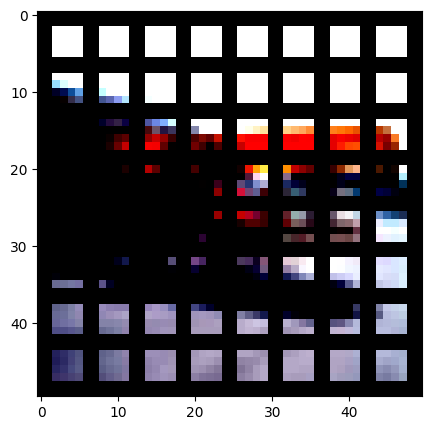

In [10]:
def image_batch_to_patches(image_batch, patch_size):
    batch_size, channels, height, width = image_batch.shape
    num_patches_height = height // patch_size
    num_patches_width = width // patch_size
    patches = torch.zeros((batch_size, num_patches_height * num_patches_width,
                          channels, patch_size, patch_size), dtype=image_batch.dtype)

    for i in range(batch_size):
        img = image_batch[i]
        for h in range(num_patches_height):
            for w in range(num_patches_width):
                patch = img[:, h * patch_size:(h + 1) * patch_size,
                            w * patch_size:(w + 1) * patch_size]
                patches[i, h * num_patches_width + w] = patch

    return patches

def imshow(img):
    npimg = img.squeeze().detach().numpy()
    plt.figure(figsize=(5,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

after_patching = image_batch_to_patches(images, 4)
print(after_patching.shape)
imshow(torchvision.utils.make_grid(after_patching[0]))

In [40]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.layerNorm1 = nn.LayerNorm(256)
        self.mla = nn.MultiheadAttention(256, 8, 0.2)
        self.layerNorm2 = nn.LayerNorm(256)
        self.linear1 = nn.Linear(256, 512)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.2)
    
    def first_block(self, x):
        x = self.layerNorm1(x)
        x, _ = self.mla(x, x, x)
        return x
    
    def second_block(self, x):
        x = self.layerNorm2(x)
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return self.dropout(x)

    def forward(self, x):
        x = x + self.first_block(x)
        x = x + self.second_block(x)
        return x

In [7]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float, dev).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [41]:
class VisualTransformer(nn.Module):
    def __init__(self, num_patches, embedding_dim, num_transformer_blocks):
        super(VisualTransformer, self).__init__()
        self.embedding = nn.Linear(48, embedding_dim)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embedding_dim))
        self.positional_encoding = PositionalEncoding(embedding_dim, num_patches + 1)
        self.transformer_blocks = nn.ModuleList([Transformer() for _ in range(num_transformer_blocks)])
        self.layerNorm = nn.LayerNorm(embedding_dim)
        self.linear = nn.Linear(embedding_dim, 10)
        
    def forward(self, x):
        x = image_batch_to_patches(x, 4)
        x = x.view(x.size(0), x.size(1), -1)
        x = self.embedding(x)
        x = torch.cat((self.class_token.repeat(16, 1, 1), x), dim=1)
        x = self.positional_encoding(x)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        x = self.layerNorm(x)
        x = x[:, 0]
        x = self.linear(x)
        return x

In [42]:
VisualTransformer = VisualTransformer(64, 256, 6)
epochs = 10
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(VisualTransformer.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = VisualTransformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / 2000))
    running_loss = 0.0

KeyboardInterrupt: 